# Seurat: Xenium
conda env: single-cell_R-4.0.3

In [1]:
library(Seurat)
library(future)
library(dplyr)
library(scales) # color palette: hue_pal()
library(ggplot2)
library(tibble)
library(ggrepel)

# Specific requirement for xenium: 
library(arrow) # -> Helps to read in .parquet file

set.seed(49)

# Function for setting the size of figures in the notebook
figsize <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantNA’ by ‘spatstat.sparse::RelevantNA’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::grokIndexVector’ by ‘spatstat.sparse::grokIndexVector’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::fullIndexSequence’ by ‘spatstat.sparse::fullIndexSequence’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::positiveIndex’ by ‘spatstat.sparse::positiveIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::replacementIndex’ by ‘spatstat.sparse::replacementIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantEmpty’ by ‘spatstat.sparse::RelevantEmpty’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::isRelev

In [ ]:
dir = "/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/spatial_datasets/Xenium5k_NSCLC"

In [3]:
# PanCancer scRNA-seq reference data
pancancer_sc <- readRDS("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/PanCancer/TC_noLQ_fUMAP_08-03-2024.rds")

# Create spatial object (V5->V4)
obj_v5 <- readRDS(paste0(dir, "/xenium5k_obj_TC.rds"))
obj <- CreateSeuratObject(counts = obj_v5[['Xenium']]@counts, meta.data = obj_v5@meta.data, assay = "Xenium")
# obj$RCTD.predicted_celltype %>% unique()

[1] "Summary of uniqueRNA"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  101.0   150.0   195.0   209.7   249.0   859.0 
[1] "Summary of counts"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  103.0   175.0   233.0   257.4   307.0  1653.0 


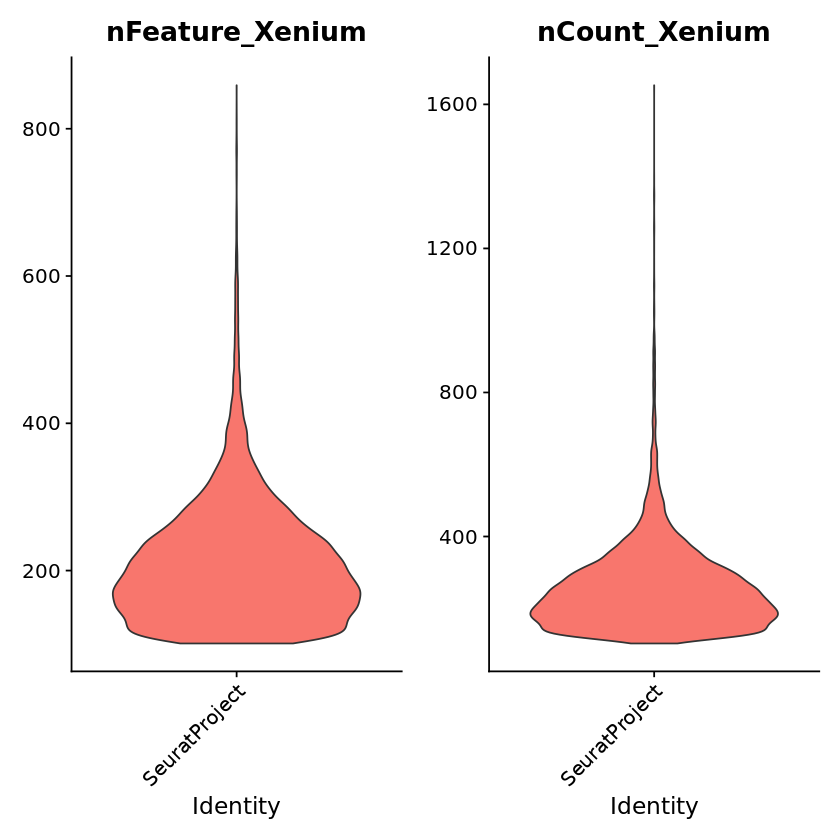

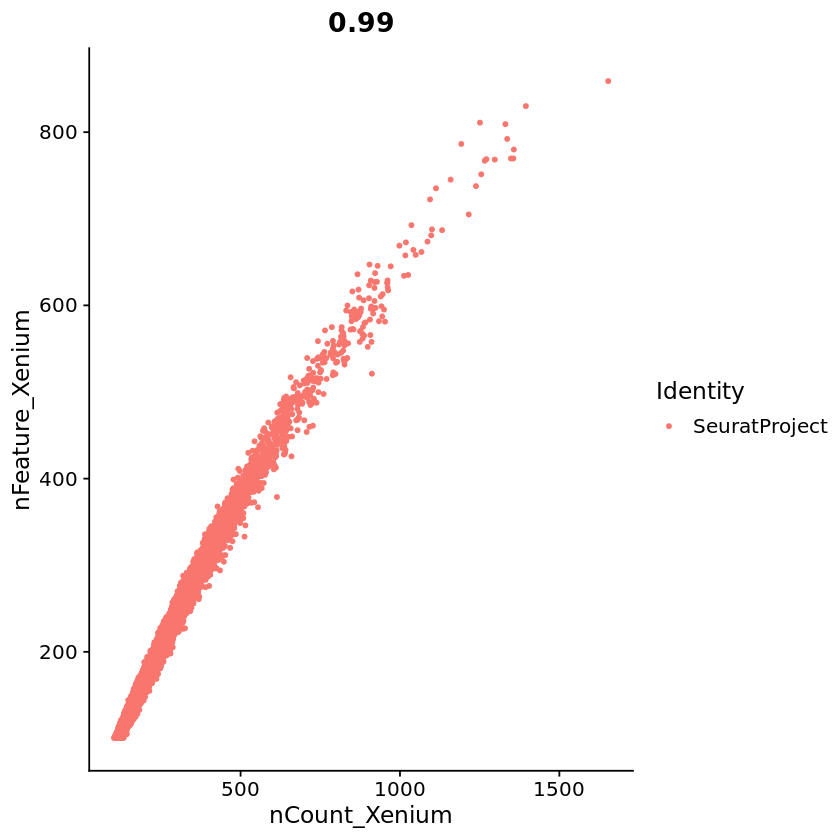

In [4]:
print("Summary of uniqueRNA")
print(summary(obj$nFeature_Xenium))
print("Summary of counts")
print(summary(obj$nCount_Xenium))

Idents(obj) <- "SeuratProject"
VlnPlot(obj, features = c("nFeature_Xenium", "nCount_Xenium"), ncol = 2, pt.size = 0)
FeatureScatter(obj, feature1 = "nCount_Xenium", feature2 = "nFeature_Xenium") 

In [5]:
# Clean everything in case we did the PCA analysis before
obj <- DietSeurat(obj)

# Normalize data and calculate cell cycle scores
obj <- NormalizeData(obj, normalization.method = "LogNormalize", scale.factor = 10000)
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
obj <- CellCycleScoring(obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: GINS2, CDCA7, DTL, PRIM1, MLF1IP, RFC2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, ATAD2, CDC45, TIPIN, DSCC1, USP1, CLSPN, POLA1, CHAF1B, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NDC80, NUF2, CKS1B, TACC3, FAM64A, CKAP2L, TUBB4B, GTSE1, KIF20B, HJURP, HN1, NCAPD2, DLGAP5, CDCA8, ECT2, KIF23, ANLN, LBR, CENPE, G2E3, GAS2L3, not searching for symbol synonyms”


In [6]:
# Perform cluster analysis
obj <- FindVariableFeatures(obj, nfeatures = 2000) %>%
        ScaleData(do.scale=TRUE, vars.to.regress = c("S.Score", "G2M.Score")) %>%
        RunPCA(npcs=30) %>%
        RunUMAP(dims = 1:30, min.dist=0.05) %>%
        FindNeighbors(reduction = "pca", dims = 1:30) %>%
        FindClusters(resolution = c(0.1, 0.2, 0.3, 0.5, 0.8))

Regressing out S.Score, G2M.Score

Centering and scaling data matrix

PC_ 1 
Positive:  EPCAM, ITGAE, LAPTM4B, HHLA2, EPDR1, CLPTM1L, CDH1, CD8A, MACC1, FOLR1 
	   GZMB, DDR1, LAMB3, ST14, TSPAN13, CXCL13, AGR3, CTSH, VSTM2L, TMPRSS2 
	   PDIA4, CTTN, NKX2-1, CP, SH3BGRL2, TNFRSF9, PLS3, PON2, PKM, LDHA 
Negative:  EEF1G, CXCR4, PIK3R1, GIMAP4, SELL, ADAMTS1, ERN1, TC2N, S1PR1, GPRASP1 
	   PTGER2, ATM, VGLL3, TENT5C, CXCL12, TCF21, CCR4, MAF, CCL19, SORL1 
	   DPT, INMT, PDE5A, CCDC80, CD4, CALCRL, MYH10, RTKN2, AOC3, SLIT3 
PC_ 2 
Positive:  CD8A, GZMB, GZMH, EPCAM, EPAS1, GZMA, AGER, LAMB3, EMP2, HOPX 
	   TSPAN13, FOLR1, MALL, ITGAE, DHCR24, AGR3, SLC9A3R2, PLS3, CST7, EPDR1 
	   TMPRSS2, DDR1, METRNL, FGFBP2, ANXA3, SPON2, BCAM, PTPRF, HHLA2, VSTM2L 
Negative:  FOXP3, CTLA4, CD4, CCR4, SELL, IKZF2, BATF, TIGIT, PIM2, CCL19 
	   ICA1, IL2RA, RTKN2, PVT1, IL6ST, PBXIP1, CD79A, STAT1, SESN3, NFKB2 
	   ITGA4, CSK, IL6R, POU2AF1, CHD3, MAF, GBP5, GLCCI1, CCR8, PKM 
PC_ 3 
Positive:  L

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17359
Number of edges: 444085

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9234
Number of communities: 3
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17359
Number of edges: 444085

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8756
Number of communities: 6
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17359
Number of edges: 444085

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8457
Number of communities: 9
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17359
Number of edges: 444085

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8148
Number of communities: 12
Elapsed time: 2 seconds
Modularity Opti

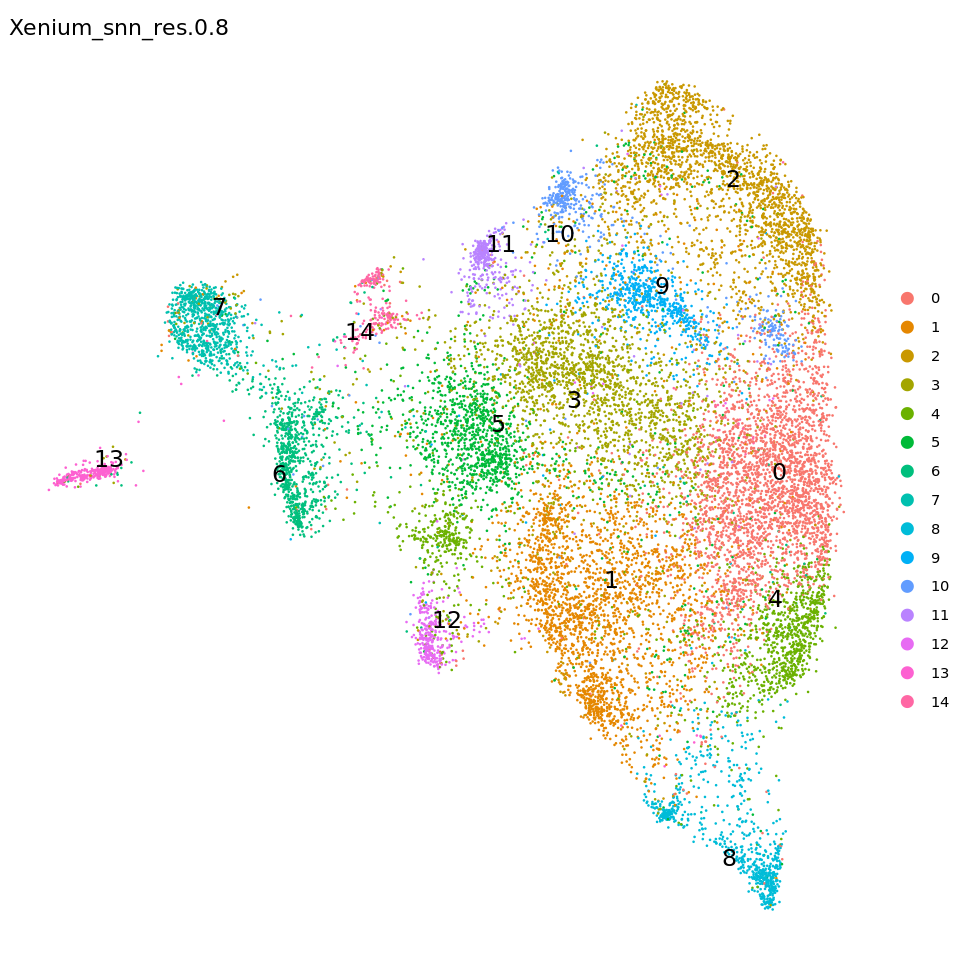

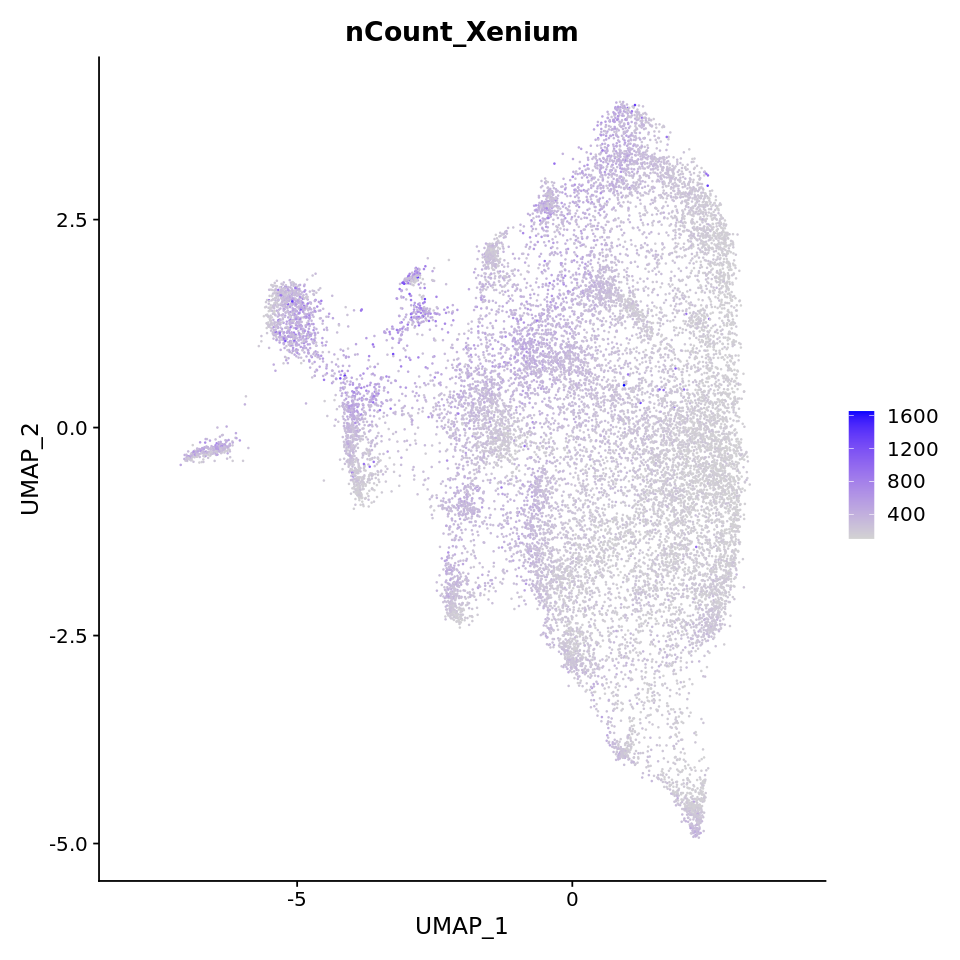

In [7]:
figsize(8, 8)
DimPlot(obj, group.by = "Xenium_snn_res.0.8", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()# + NoLegend()
FeaturePlot(obj, features = "nCount_Xenium")

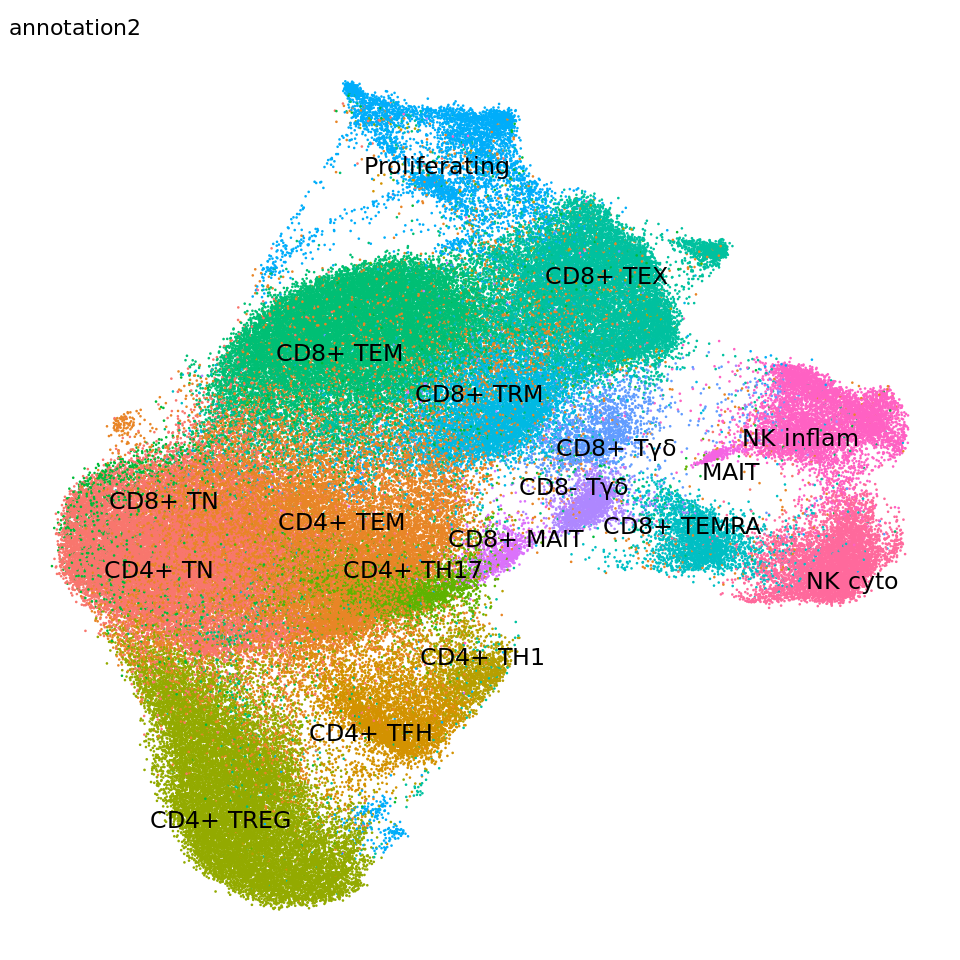

In [8]:
# Subtype annotation in reference dataset (PanCancer atlas)
figsize(8, 8)
DimPlot(pancancer_sc, group.by = "annotation2", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()+ NoLegend()

## Seurat Integration
Credit: Sam

In [9]:
# Clean the spatial data
DefaultAssay(obj) <- "Xenium"
obj$Batch <- "Xenium"
pancancer_sc$Batch <- "Single-cell"

In [10]:
# Get the common genes between the two datasets
common_genes <- rownames(obj)[rownames(obj) %in% rownames(pancancer_sc)]
pancancer_sc <- pancancer_sc[common_genes, ]

In [11]:
# Create query subset
obj.query <- obj
obj.query <- obj.query[common_genes, ]

# Create reference dataset
obj.ref <- pancancer_sc
obj.ref$annotation2 <- factor(obj.ref$annotation2)

In [12]:
obj.ref
obj.query

An object of class Seurat 
5001 features across 147672 samples within 1 assay 
Active assay: RNA (5001 features, 557 variable features)
 3 dimensional reductions calculated: pca, umap, harmony

An object of class Seurat 
5001 features across 17359 samples within 1 assay 
Active assay: Xenium (5001 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [13]:
options(future.globals.maxSize= 6000*1024^2)

obj.query <- NormalizeData(obj.query)
obj.anchors <- FindTransferAnchors(reference = obj.ref,
                                        query = obj.query,
                                        dims = 1:30,
                                        reference.reduction = "pca")

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 33117 anchors

Filtering anchors

	Retained 5763 anchors



In [14]:
predictions <- TransferData(anchorset = obj.anchors, refdata = obj.ref$annotation2, dims = 1:30)
obj.query <- AddMetaData(obj.query, metadata = predictions)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [15]:
options(scipen = 999)
round(100*prop.table(table(obj.query$predicted.id)), 2)
round(100*prop.table(table(obj.ref$annotation2)), 2)


     CD4+ TEM      CD4+ TFH      CD4+ TH1     CD4+ TH17       CD4+ TN 
        10.12          5.75          0.21          5.14         28.10 
    CD4+ TREG      CD8- Tγδ     CD8+ MAIT      CD8+ TEM    CD8+ TEMRA 
        21.19          0.01          0.10         13.95          0.50 
     CD8+ TEX       CD8+ TN      CD8+ TRM      CD8+ Tγδ          MAIT 
         7.96          0.04          0.80          0.13          0.05 
      NK cyto     NK inflam Proliferating 
         1.39          0.36          4.18 


      CD4+ TN      CD4+ TEM      CD4+ TFH      CD4+ TH1     CD4+ TREG 
        14.91         17.69          3.11          1.19         11.75 
    CD4+ TH17       CD8+ TN      CD8+ TEM      CD8+ TEX    CD8+ TEMRA 
         2.24          1.40         15.24         10.20          2.02 
     CD8+ TRM Proliferating      CD8+ Tγδ      CD8- Tγδ     CD8+ MAIT 
         4.96          3.65          1.39          1.24          0.69 
         MAIT     NK inflam       NK cyto 
         0.28          4.18          3.86 

In [16]:
obj.ref <- RunUMAP(obj.ref, dims = 1:30, reduction = "pca", return.model = TRUE)
obj.query <- MapQuery(anchorset = obj.anchors, reference = obj.ref, query = obj.query,
    refdata = list(celltype = "annotation2"), reference.reduction = "pca", reduction.model = "umap")

UMAP will return its model

17:45:11 UMAP embedding parameters a = 0.9922 b = 1.112

17:45:11 Read 147672 rows and found 30 numeric columns

17:45:11 Using Annoy for neighbor search, n_neighbors = 30

17:45:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:45:27 Writing NN index file to temp file /tmp/RtmpPJHX03/file2c5e3814983f5e

17:45:27 Searching Annoy index using 1 thread, search_k = 3000

17:46:48 Annoy recall = 100%

17:46:48 Commencing smooth kNN distance calibration using 1 thread

17:46:54 Initializing from normalized Laplacian + noise

17:47:00 Commencing optimization for 200 epochs, with 6798360 positive edges

17:48:40 Optimization finished

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Integrating dataset 2 w

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



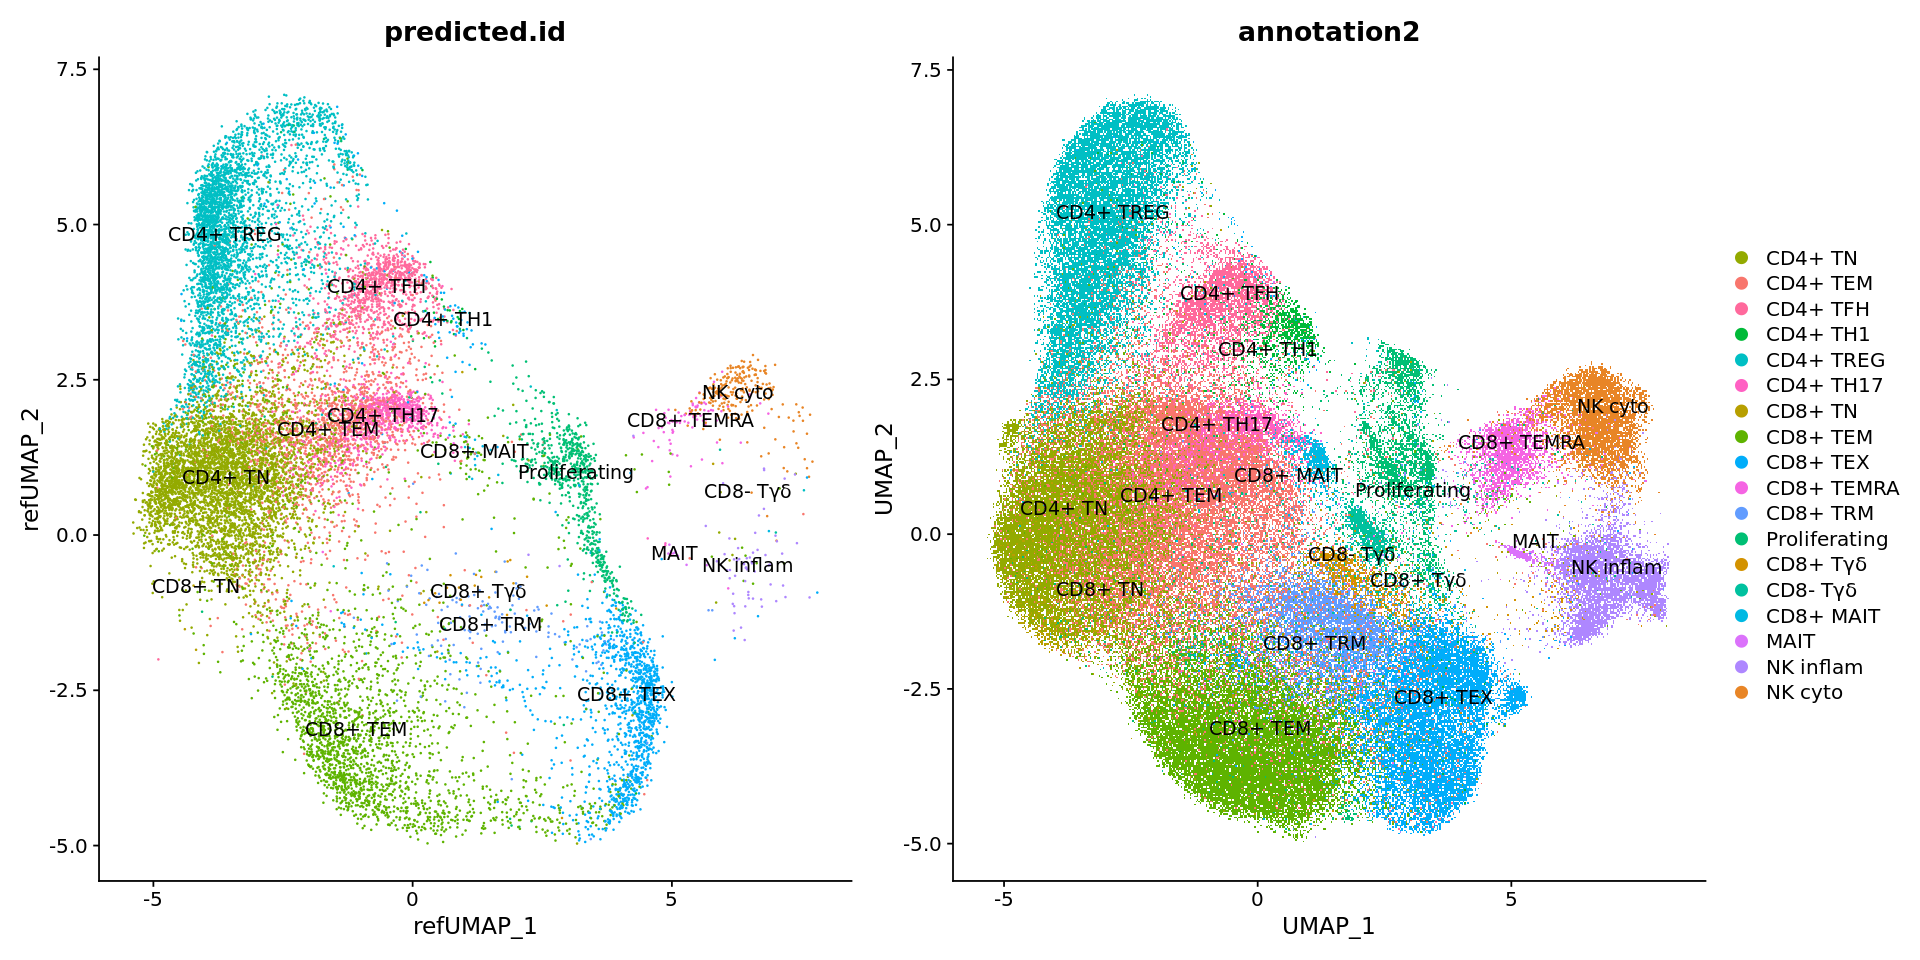

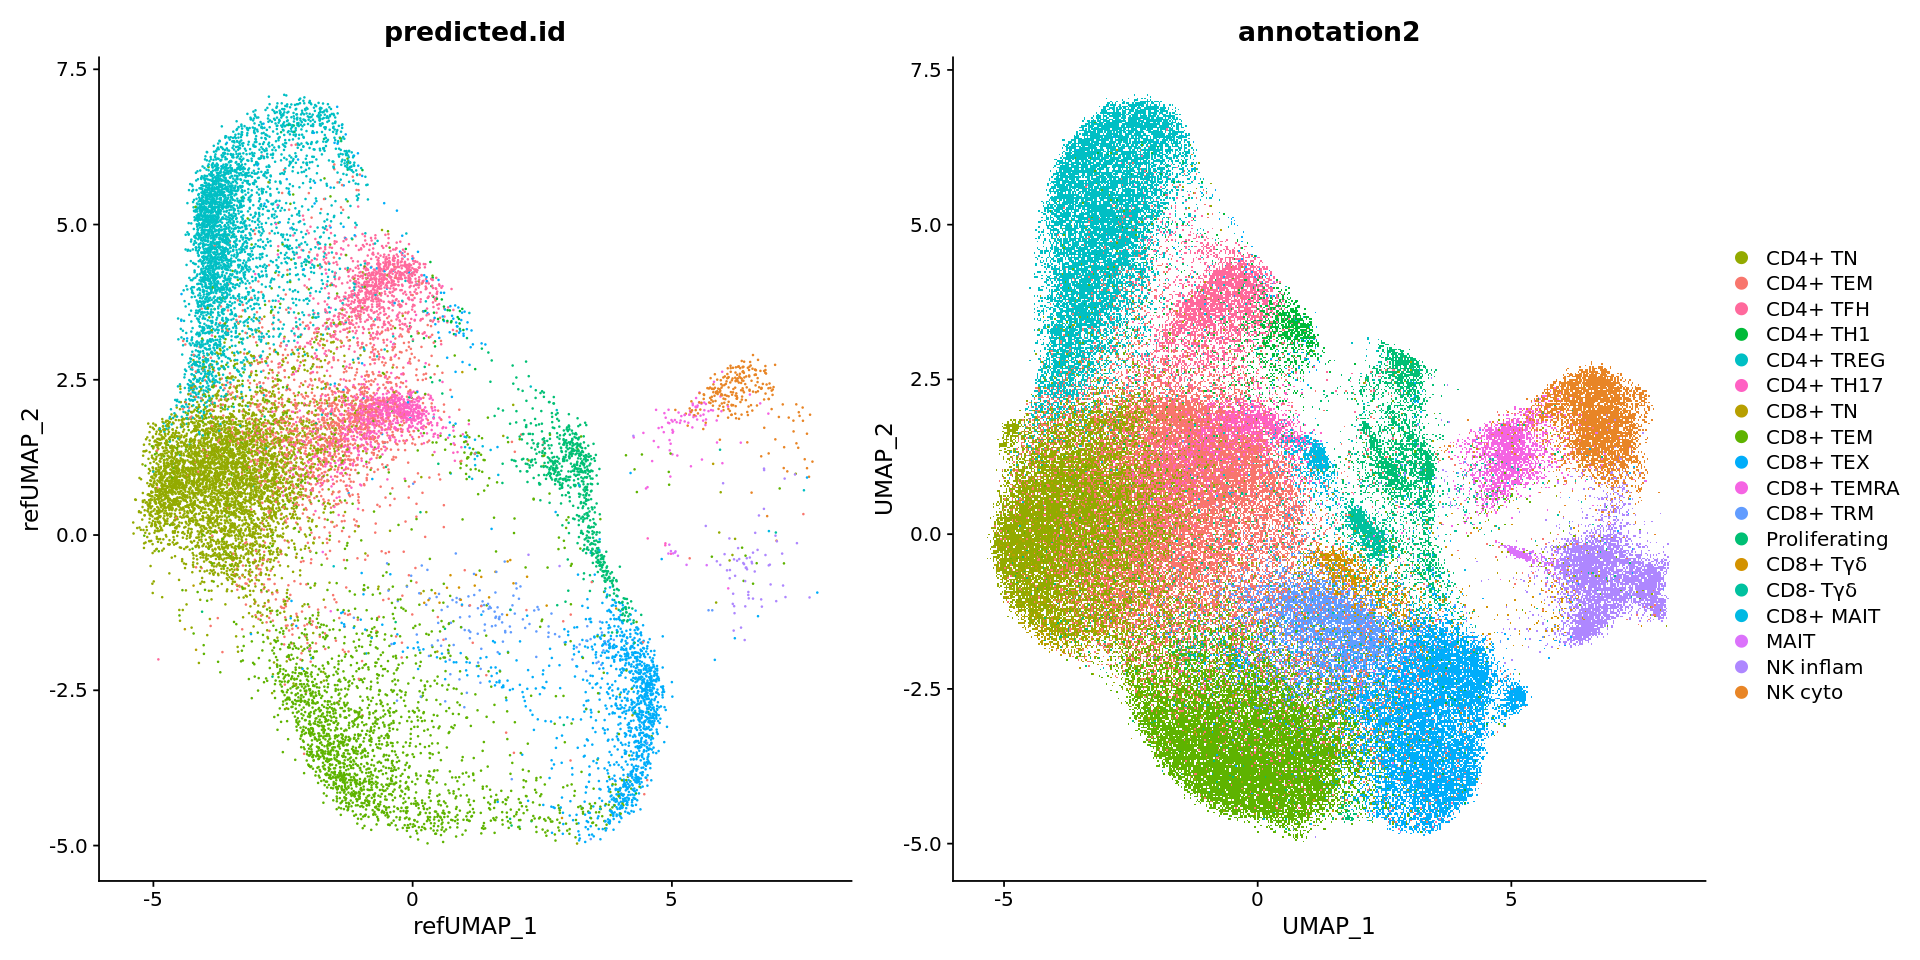

In [17]:
dd.col <- hue_pal()(length(unique(pancancer_sc$annotation2)))
names(dd.col) <- unique(pancancer_sc$annotation2)

figsize(16, 8)
(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id", label=TRUE) + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="annotation2", label=TRUE, repel = TRUE) & 
    scale_color_manual(values = dd.col) 

(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id") + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="annotation2") & 
    scale_color_manual(values = dd.col)

In [ ]:
saveRDS(obj.query, file.path(dir, "TC_query.rds"))
saveRDS(obj.ref, file.path(dir, "TC_ref.rds"))

## Validate annotation - heatmap

In [20]:
obj.query <- readRDS(file.path(dir, "TC_query.rds"))
obj.ref <- readRDS(file.path(dir, "TC_ref.rds"))

In [22]:
Idents(obj) <- obj$`Xenium_snn_res.0.8`
markers <- FindAllMarkers(obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.5)
#write.csv(markers, file = paste0(dir, "/FindAllMarkers_TC.csv"), row.names = FALSE)

Calculating cluster 0



Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [18]:
source("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/Figure_functions.R")

TC_CD4_gene_list <- list(`CD4+ TN` = c("CCR7", "PLAC8", "ICAM2", "MYC", "LEF1"),
                    `CD4+ TEM` = c("GZMH", "ANKRD28", "ANXA1", "EOMES", "GZMK"),
                    `CD4+ TFH` = c("NMB", "ICA1", "CXCR5", "BCL6"),
                    `CD4+ TH1` = c("TBX21", "LAG3", "IFNG", "HAVCR2", "GZMB"),
                    `CD4+ TREG` = c("FOXP3", "IKZF2", "IL2RA", "IL1R2", "IL1R1"),
                    `CD4+ TH17` = c("RORC", "IL17A", "CCR6"))
                    
TC_CD8_gene_list <- list(`CD8+ TN` = c("CCR7", "TCF7", "LEF1", "CD55", "MAL"),
                    `CD8+ TEM` = c("GZMK", "CD74", "EOMES", "GZMA", "ITM2C"),
                    `CD8+ TEX` = c("LAG3", "CTLA4", "TIGIT", "ENTPD1", "TOX2"),
                    `CD8+ TEMRA` = c("CX3CR1", "FGFBP2", "FCGR3A", "SPON2", "PRF1"),
                    `CD8+ TRM` = c("TOB1", "ITGAE", "ZNF683", "CCL5", "ITGA1"),
                    `CD8+ Tγδ` = c("TRDC", "TRG-AS1", "TRDV1", "KIR3DL2"),
                    `CD8+ MAIT` = c("SLC4A10", "CCR6", "IL4I1", "KLRB1", "RORC"))

TC_other_gene_list <- list(`Proliferation` = c("TOP2A", "MKI67"),
                    `Tγδ` = c("TRDC", "TRGC2", "TRG-AS1", "TRDV1", "TRDV2"),
                    `MAIT` = c("SLC4A10", "CCR6", "IL4I1", "KLRB1", "RORC"),
                    `NK inflam` = c("NCAM1", "XCL1", "XCL2", "KLRC1"),
                    `NK cyto` = c("FCGR3A", "CX3CR1", "FGFBP2", "NKG7", "PRF1"))
                

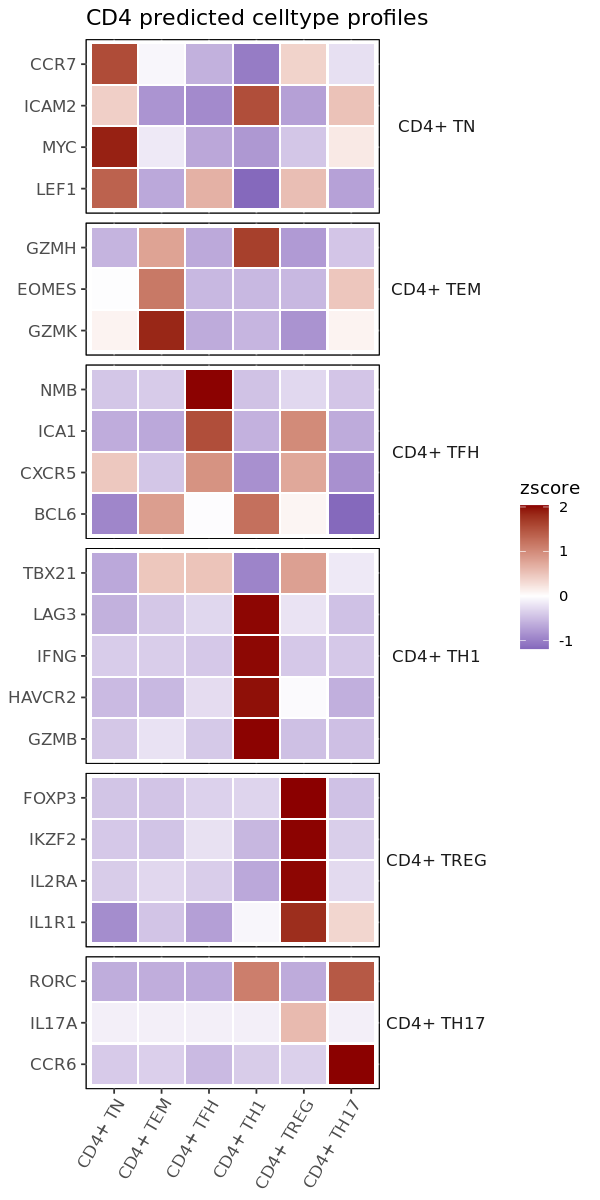

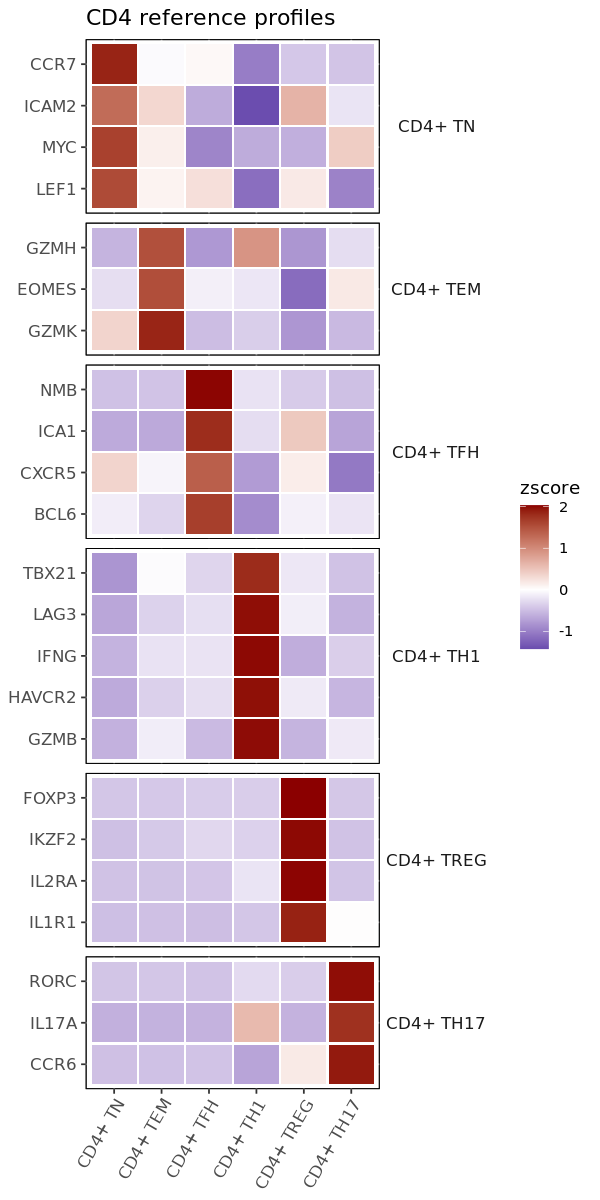

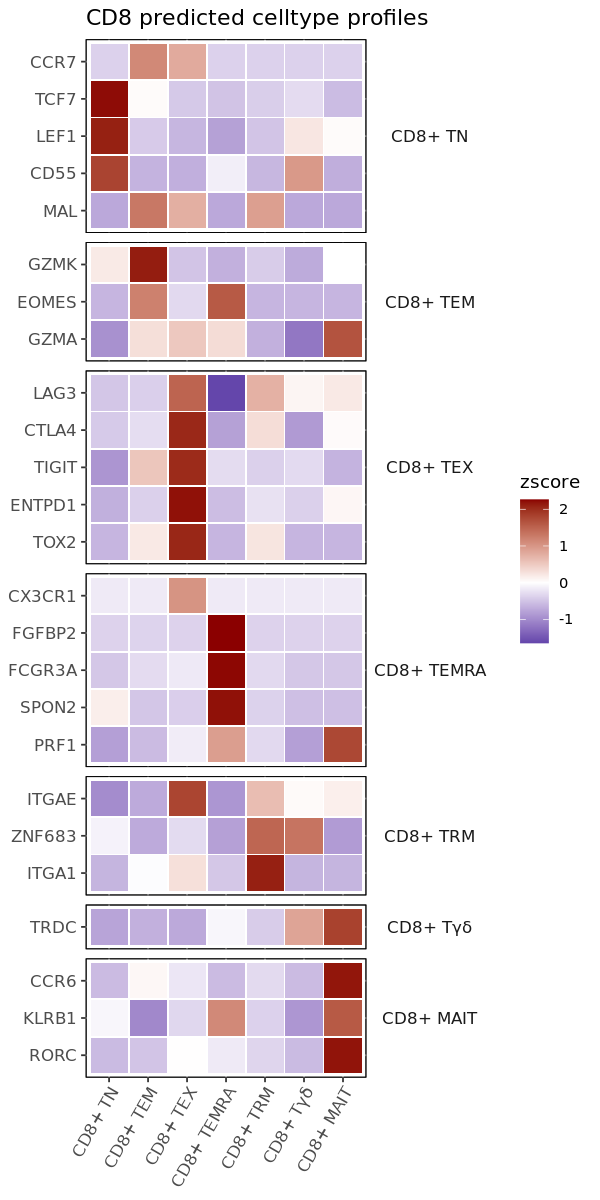

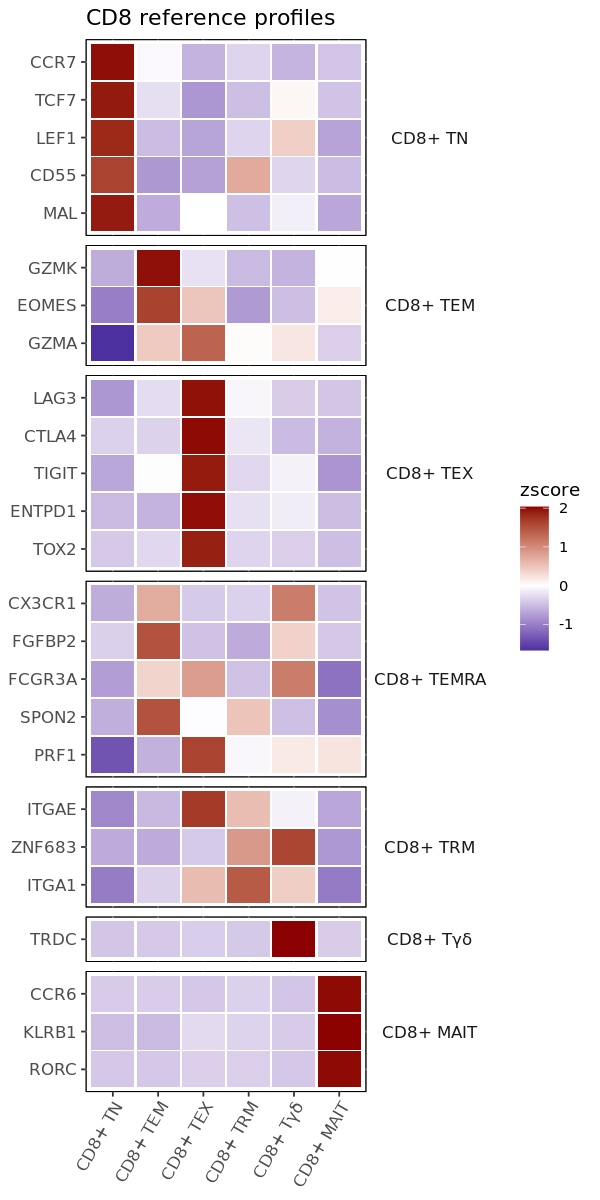

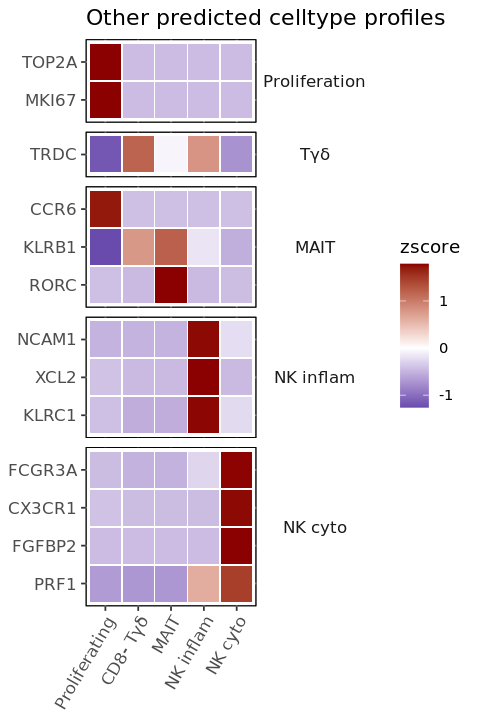

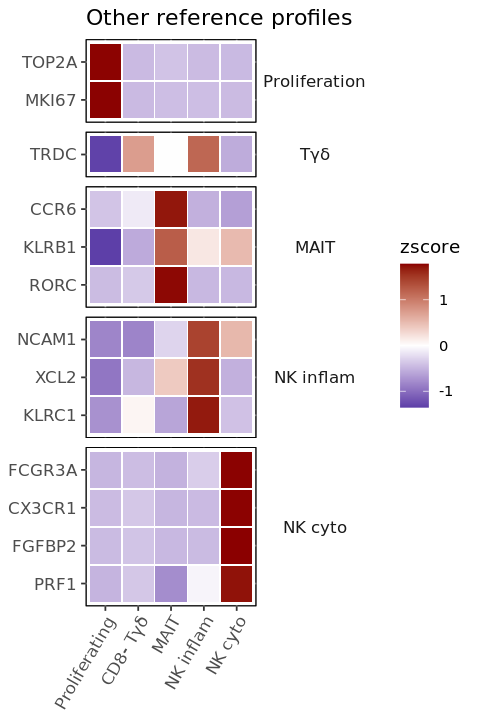

In [21]:
# obj.query$cluster_rename <- paste0("cluster_", obj.query$`Xenium_snn_res.0.8`)
# heatmap(obj.query, genes = TC_gene_list, assay = "Xenium", group.by = "cluster_rename")

# CD4 T-cells
figsize(5, 10)
obj.query.cd4 <- subset(obj.query, subset = predicted.id %in% c("CD4+ TN", "CD4+ TEM", "CD4+ TFH", "CD4+ TH1", "CD4+ TH17", "CD4+ TREG"))
pancancer_sc.cd4 <- subset(pancancer_sc, subset = annotation2 %in% c("CD4+ TN", "CD4+ TEM", "CD4+ TFH", "CD4+ TH1", "CD4+ TH17", "CD4+ TREG"))
obj.query.cd4$predicted.id <- factor(obj.query.cd4$predicted.id, levels = levels(pancancer_sc.cd4$annotation2))
heatmap(obj.query.cd4, genes = TC_CD4_gene_list, assay = "Xenium", group.by = "predicted.id") + ggtitle("CD4 predicted celltype profiles")
heatmap(pancancer_sc.cd4, genes = TC_CD4_gene_list, assay = "RNA", group.by = "annotation2") + ggtitle("CD4 reference profiles")

# CD8 T-cells
figsize(5, 10)
obj.query.cd8 <- subset(obj.query, subset = predicted.id %in% c("CD8+ TN", "CD8+ TEM", "CD8+ TEX", "CD8+ TEMRA", "CD8+ TRM", "CD8+ Tγδ", "CD8+ MAIT"))
pancancer_sc.cd8 <- subset(pancancer_sc, subset = annotation2 %in% c("CD8+ TN", "CD8+ TEM", "CD8+ TEX", "CD8+ TH1", "CD8+ TH17", "CD8+ TRM", "CD8+ Tγδ", "CD8+ MAIT"))
obj.query.cd8$predicted.id <- factor(obj.query.cd8$predicted.id, levels = levels(pancancer_sc.cd8$annotation2))
heatmap(obj.query.cd8, genes = TC_CD8_gene_list, assay = "Xenium", group.by = "predicted.id") + ggtitle("CD8 predicted celltype profiles")
heatmap(pancancer_sc.cd8, genes = TC_CD8_gene_list, assay = "RNA", group.by = "annotation2") + ggtitle("CD8 reference profiles")

# Others
figsize(4, 6)
obj.query.other <- subset(obj.query, subset = predicted.id %in% c("Proliferating", "CD8- Tγδ", "MAIT", "NK inflam", "NK cyto"))
pancancer_sc.other <- subset(pancancer_sc, subset = annotation2 %in% c("Proliferating", "CD8- Tγδ", "MAIT", "NK inflam", "NK cyto"))
obj.query.other$predicted.id <- factor(obj.query.other$predicted.id, levels = levels(pancancer_sc.other$annotation2))
heatmap(obj.query.other, genes = TC_other_gene_list, assay = "Xenium", group.by = "predicted.id") + ggtitle("Other predicted celltype profiles")
heatmap(pancancer_sc.other, genes = TC_other_gene_list, assay = "RNA", group.by = "annotation2") + ggtitle("Other reference profiles")